In [38]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client 

In [ ]:
# establish anonymous connection (public endpoints only)
client = Client()

# obtains BTC/USDT funding rate data
funding = client.futures_funding_rate(symbol = "BTCUSDT", limit = 1000)

# creates a df with each row representing an 8-hour funding event
funding_df = pd.DataFrame(funding)

# rounding down timestamps to enable merge
funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"], unit = "ms")
funding_df["timestamp"] = funding_df["fundingTime"].dt.floor("8h")

# formating and defining final df
funding_df["fundingRate"] = funding_df["fundingRate"].astype(float)
funding_df = funding_df[["timestamp","fundingRate"]]
funding_df

,timestamp,fundingRate
0,2025-11-11 00:00:00,0.000028
1,2025-11-11 08:00:00,-0.000028
2,2025-11-11 16:00:00,0.000058
3,2025-11-12 00:00:00,0.000025
4,2025-11-12 08:00:00,0.000007
...,...,...
195,2026-01-15 00:00:00,-0.000004
196,2026-01-15 08:00:00,0.000017
197,2026-01-15 16:00:00,0.000015
198,2026-01-16 00:00:00,0.000073


In [30]:
# fetches mark price data (OHLC) for BTC/USDT
mark_klines = client.futures_mark_price_klines(symbol = "BTCUSDT", interval = "8h", limit = 200)

# creates a mark price df and labels columns
price_df = pd.DataFrame(mark_klines, columns = 
                       ["open_time", "open", "high", "low", "close_price",
                        "ignore1", "close_time", "ignore2", "ignore3", "ignore4",
                        "ignore5", "ignore6"])

## price_df = price_df.drop(columns = ["ignore1", "ignore2", "ignore3", "ignore4", "ignore5", "ignore6", "open", "high", "low"])

# format column types and define df
price_df["timestamp"] = pd.to_datetime(price_df["open_time"], unit = "ms")
price_df["close_price"] = price_df["close_price"].astype(float)

price_df = price_df[["timestamp","close_price"]]

price_df

,timestamp,close_price
0,2025-11-11 00:00:00,104737.000000
1,2025-11-11 08:00:00,103431.508949
2,2025-11-11 16:00:00,103007.545812
3,2025-11-12 00:00:00,103070.028449
4,2025-11-12 08:00:00,102175.668333
...,...,...
195,2026-01-15 00:00:00,96606.597710
196,2026-01-15 08:00:00,96738.752233
197,2026-01-15 16:00:00,95567.400000
198,2026-01-16 00:00:00,95608.200000


In [ ]:
# generate final merged and sorted df and calc log_returns adding a forward shift

BTCUSDT_df = pd.merge(funding_df,price_df, on = "timestamp", how = "inner").sort_values("timestamp")
BTCUSDT_df["log_returns"] = np.log(BTCUSDT_df["close_price"] / BTCUSDT_df["close_price"].shift(1)
    ).shift(-1)

BTCUSDT_df = BTCUSDT_df.dropna()

BTCUSDT_df

,timestamp,fundingRate,close_price,log_returns
0,2025-11-11 00:00:00,0.000028,104737.000000,-0.012543
1,2025-11-11 08:00:00,-0.000028,103431.508949,-0.004107
2,2025-11-11 16:00:00,0.000058,103007.545812,0.000606
3,2025-11-12 00:00:00,0.000025,103070.028449,-0.008715
4,2025-11-12 08:00:00,0.000007,102175.668333,-0.005593
...,...,...,...,...
194,2026-01-14 16:00:00,0.000041,96907.900000,-0.003114
195,2026-01-15 00:00:00,-0.000004,96606.597710,0.001367
196,2026-01-15 08:00:00,0.000017,96738.752233,-0.012182
197,2026-01-15 16:00:00,0.000015,95567.400000,0.000427


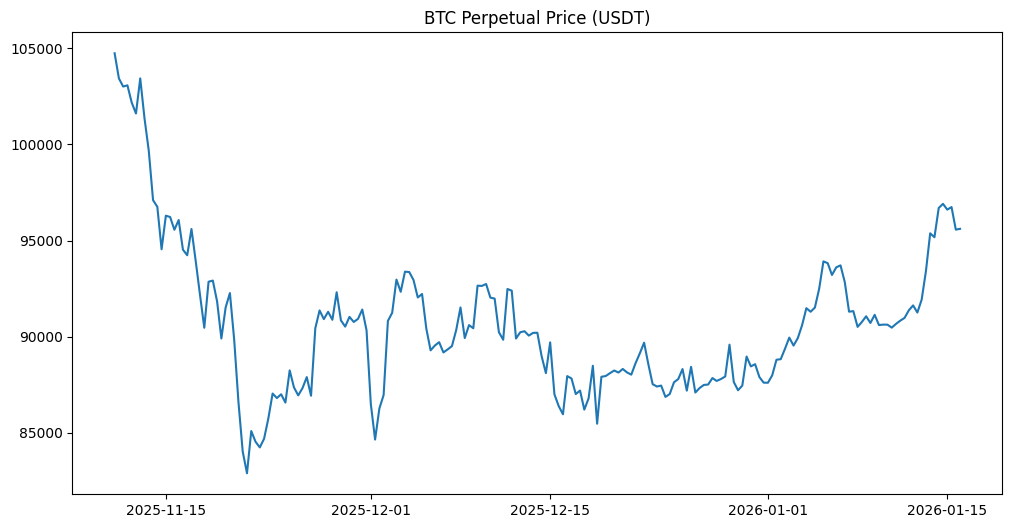

In [46]:
# plot BTC Perpetual Price data

plt.figure(figsize =(12,6))
plt.plot(BTCUSDT_df['timestamp'], BTCUSDT_df['close_price'])
plt.title("BTC Perpetual Price (USDT)")
plt.show()



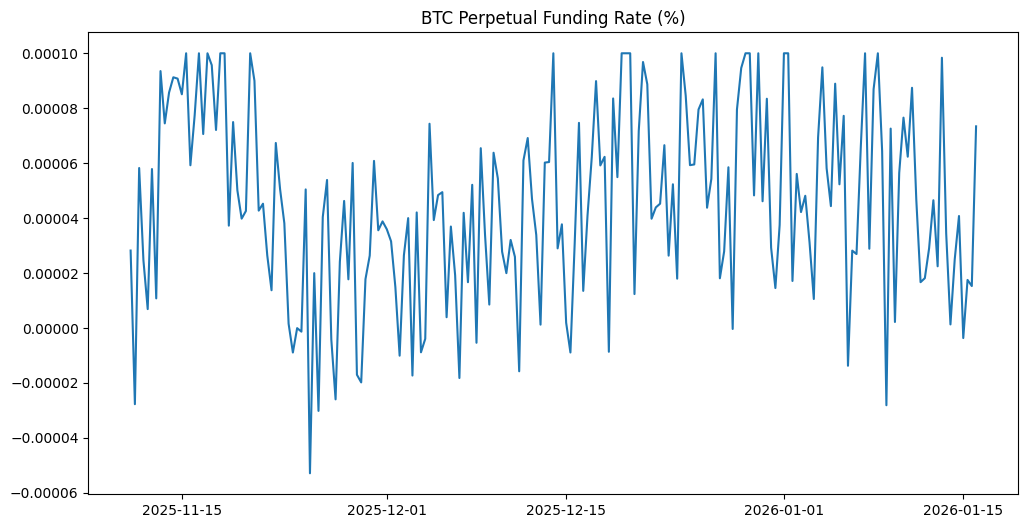

In [45]:
# plot BTC Perpetual funding rate data


plt.figure(figsize =(12,6))
plt.plot(BTCUSDT_df['timestamp'], BTCUSDT_df['fundingRate'])
plt.title("BTC Perpetual Funding Rate (%)")
plt.show()


In [54]:
# # prints current working directory
# import os
# os.getcwd()

# save df to a CSV file
BTCUSDT_df.to_csv("../data/btc_funding_8h.csv", index = False)